# Tropical storms of CONUS

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
tracks_file = "/home/simon/Downloads/IBTrACS.ALL.v04r01.nc"
tracks = xr.load_dataset("/home/simon/Downloads/IBTrACS.ALL.v04r01.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/home/simon/Downloads/IBTrACS.ALL.v04r01.nc'

In [ ]:
time = tracks.time 
inds = ((np.datetime64("2022-01-01") < time) * (time < np.datetime64("2023-01-01"))).any("date_time")
tracks_2022 = tracks[{"storm": inds}]

In [ ]:
from tqdm import tqdm
import shapely
from pansat import FileRecord, TimeRange
from pansat.granule import Granule
from pansat.geometry import ShapelyGeometry
from pansat.catalog.index import _granules_to_dataframe

granules = []
for storm in tqdm(range(tracks_2022.storm.size)):
    track_data = tracks_2022[{"storm": storm}]
    n_obs = int(track_data.numobs.item())
    for ind in range(n_obs - 1):
        segment = track_data[{"date_time": slice(ind, ind + 2)}]
        start_time = segment.time[0].data
        end_time = segment.time[1].data
        geometry = ShapelyGeometry(shapely.LineString(np.stack([segment.lon.data, segment.lat.data], -1)))
        granules.append(Granule(
            FileRecord(tracks_file),
            TimeRange(start_time, end_time),
            geometry=geometry,
            primary_index_name="storm",
            primary_index_range=(storm, storm + 1),
            secondary_index_name="date_time",
            secondary_index_range=(ind, ind + 1),
        ))
        
track_index = _granules_to_dataframe(granules)

In [5]:
from pansat.products.ground_based.mrms import MRMS_DOMAIN

conus_mask = track_index["geometry"].apply(lambda x: x.intersects(MRMS_DOMAIN.to_shapely()))
tracks_conus = track_index[conus_mask]

In [7]:
from pansat.products.satellite.noaa.gaasp import l1b_gcomw1_amsr2
from pansat.environment import get_index

In [8]:
from pansat.catalog import Index
l1b_index = Index.load(l1b_gcomw1_amsr2, "/edata2/simon/satellite_data/.pansat_catalog/")

In [9]:
dframe = l1b_index.data.load()

In [10]:
mask = dframe["geometry"] == None


In [11]:
dframe[mask]

,start_time,end_time,local_path,remote_path,filename,primary_index_name,primary_index_start,primary_index_end,secondary_index_name,secondary_index_start,secondary_index_end,geometry
150013,2021-01-01 05:22:28,2021-01-01 05:28:28,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010422180_e202101010...,scans,2400,2641,pixels_s1,0,243,None
150030,2021-01-01 07:06:23,2021-01-01 07:12:35,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010558170_e202101010...,scans,2717,2966,pixels_s1,0,243,None
150055,2021-01-01 09:31:59,2021-01-01 09:38:11,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010913180_e202101011...,scans,741,990,pixels_s1,0,243,None
150066,2021-01-01 10:39:54,2021-01-01 10:46:06,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010913180_e202101011...,scans,3458,3707,pixels_s1,0,243,None
150226,2021-01-02 09:02:41,2021-01-02 09:08:53,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101020819170_e202101020...,scans,1729,1978,pixels_s1,0,243,None
...,...,...,...,...,...,...,...,...,...,...,...,...
202123,2021-10-11 14:56:59,2021-10-11 15:02:59,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111350490_e202110111...,scans,2640,2881,pixels_s1,0,243,None
202132,2021-10-11 15:51:40,2021-10-11 15:57:52,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111526480_e202110111...,scans,988,1237,pixels_s1,0,243,None
202143,2021-10-11 16:59:35,2021-10-11 17:05:47,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111526480_e202110111...,scans,3705,3954,pixels_s1,0,243,None
202156,2021-10-11 19:55:54,2021-10-11 20:02:06,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111847490_e202110112...,scans,2717,2966,pixels_s1,0,243,None


In [12]:
l1b_index = get_index(l1b_gcomw1_amsr2)

Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-158_-54_-128_-21' in database but could not load find a corresponding pansat product.
Found table named 'satellite.goes.l1b_goes18_rad_c02_full_disk' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.merra.m2i3nvasm' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-163_-9_-144_6' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-166_-18_-142_19' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_pressure_levels_hourly_geopotential_temperature_sp

In [13]:
from pansat.catalog.index import find_matches
matches = find_matches(tracks_conus, l1b_index, n_processes=16)

Output()

In [14]:
print(f"Found {len(matches)} overpasses.")

Found 85 overpasses.


In [15]:
ind = 67
data = list(matches[ind][1])[0].open()

In [16]:
len(matches[ind][1])

1

/tmp/ipykernel_1852882/3025102284.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons, lats, data.tbs_s1.data[..., -1])


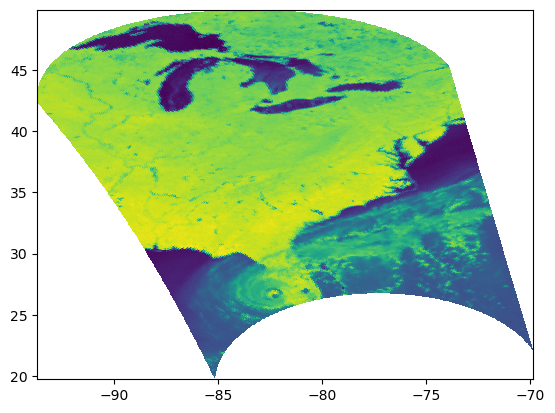

In [17]:
lons = data.longitude_s1
lats = data.latitude_s1
plt.pcolormesh(lons, lats, data.tbs_s1.data[..., -1])

## Run retrieval

In [3]:
from pytorch_retrieve.architectures import load_model
model = load_model("../noaagprof.pt")

/home/simon/src/pytorch_retrieve/pytorch_retrieve/architectures/model.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(path, map_location=torch.devic

In [4]:
import toml
from pytorch_retrieve.config import InferenceConfig

iconf = InferenceConfig.parse(model.output_config, toml.load("../inference_config_noaagprof.toml"))
model.inference_config = iconf

In [5]:
from pansat.environment import get_index
from pansat.products.satellite.noaa.gaasp import l1b_gaasp_gcomw1_amsr2
from noaagprof import InputLoader
from pytorch_retrieve.inference import run_inference

index = get_index(l1b_gaasp_gcomw1_amsr2)

Found table named 'satellite.goes.l1b_goes18_rad_c02_full_disk' in database but could not load find a corresponding pansat product.
Found table named 'satellite.cloudsat.l2c_snow_profile' in database but could not load find a corresponding pansat product.
Found table named 'satellite.cloudsat.l2c_precip_column' in database but could not load find a corresponding pansat product.
Found table named 'satellite.cloudsat.l2c_snow_profile' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_pressure_levels_hourly_geopotential_specific_humidity_specific_cloud_ice_water_content_specific_snow_water_content_specific_cloud_liquid_water_content_specific_rain_water_content_-165_-17_-143_19' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-158_-54_-128_-21' in database but could not load find a c

In [6]:
from pansat import TimeRange
time_range = TimeRange("2022-09-28T18:33:00")
granules = index.find(time_range=time_range)

In [7]:
granule = granules[0]
rng = granule.primary_index_range
granule.primary_index_range = (rng[0] - 100, rng[1] + 100)

In [8]:
model.output_config["rain_water_content"]

OutputConfig(target='rain_water_content', kind='Quantiles', shape=(28,), quantiles=16, transformation=None, dimensions=['rain_water_content_dim_1'], n_classes=None, conditional='None', encoding='None', mask='None')

In [9]:
input_loader = InputLoader(inputs=[granule])

In [10]:
results = run_inference(model, input_loader, iconf)

Output()

## Resample results

In [11]:
import satpy

In [12]:
from pyresample.area_config import create_area_def
area_def = create_area_def(
    'area',
    {'proj': 'longlat', 'datum': 'WGS84'},
    area_extent=[-86, 24, -79, 31],
    resolution=0.02,
    units='degrees',
    description='Global 1x1 degree lat-lon grid'
)

In [13]:
from pansat.utils import resample_data

results[0] = results[0].drop_vars("scan_time")
results_noaagprof = resample_data(results[0], area_def)

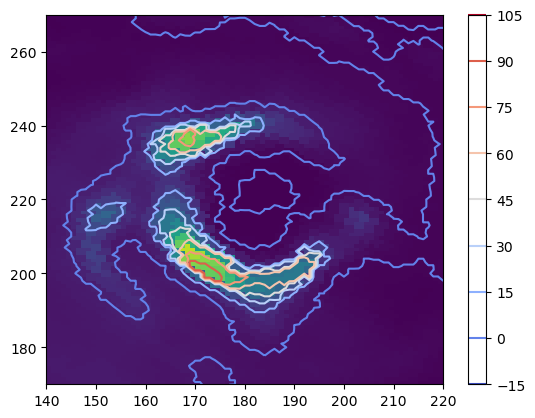

In [14]:
levels = np.linspace(-5, 5, 22)
plt.pcolormesh(results_noaagprof.surface_precip)
plt.xlim(140, 220)
plt.ylim(170, 270)
plt.contour(results_noaagprof.latent_heating[{"levels": 16}], cmap="coolwarm")
plt.colorbar()

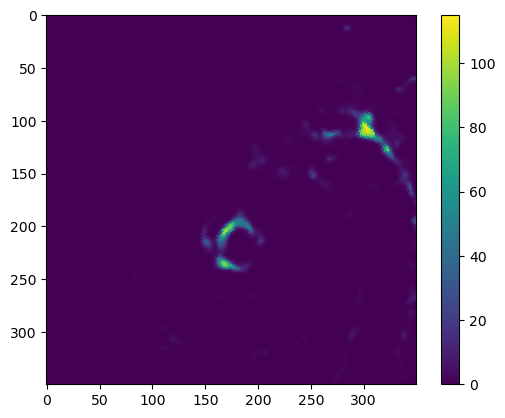

In [44]:
plt.imshow(results_noaagprof.surface_precip * results_noaagprof.convective)
plt.colorbar()

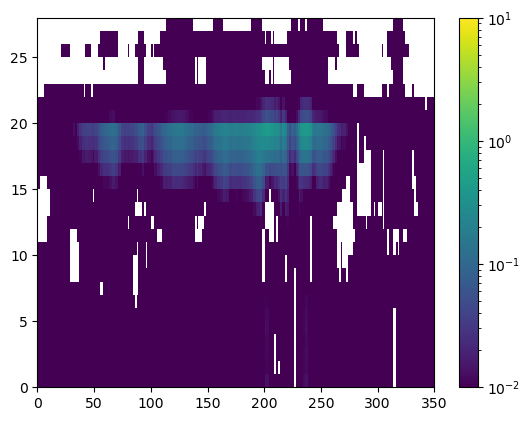

In [52]:
from matplotlib.colors import LogNorm
norm = LogNorm(1e-2, 1e1)
plt.pcolormesh(results_noaagprof.snow_water_content[:, 170, :].T, norm=norm)
plt.colorbar()

## MRMS data

In [15]:
from pansat.products.ground_based.mrms import precip_rate
recs = precip_rate.find_files(granule.time_range)
rec = recs[len(recs) // 2].get()
mrms_data = precip_rate.open(rec)

In [16]:
mrms_data = resample_data(mrms_data, area_def)

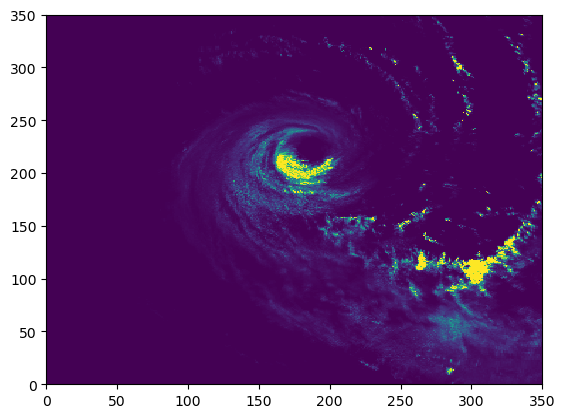

In [17]:
plt.pcolormesh(mrms_data.precip_rate, vmin=0, vmax=50)

## GPROF data

In [18]:
from pansat.products.satellite.gpm import l2a_gprof_gcomw1_amsr2

recs = l2a_gprof_gcomw1_amsr2.find_files(granule.time_range)
recs[0].get()
gprof_data = l2a_gprof_gcomw1_amsr2.open(recs[0])

Please enter your pansat user password:


 ········


Indexing of file record 'FileRecord(filename='2A.GCOMW1.AMSR2.GPROF2021v1.20220928-S180018-E193910.055137.V07A.HDF5', local_path=PosixPath('/edata1/simon/satellite_data/gpm/2a/gcomw1/amsr2/2A.GCOMW1.AMSR2.GPROF2021v1.20220928-S180018-E193910.055137.V07A.HDF5'), product=<pansat.products.satellite.gpm.GPROFProduct object at 0x7ff5ef41b2b0>, provider=<pansat.download.providers.ges_disc.GesDiscProviderDay object at 0x7ff5d6b46290>, remote_path='https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L2/GPM_2AGPROFGCOMW1AMSR2.07/2022/271/2A.GCOMW1.AMSR2.GPROF2021v1.20220928-S180018-E193910.055137.V07A.HDF5')' failed with the following error:
 This product description does not contain any granule information and can therefore not provide any granules.
Traceback (most recent call last):
  File "/gdata1/simon/micromamba/envs/noaagprof/lib/python3.10/site-packages/pansat/catalog/index.py", line 299, in index
    granules += _get_index_data(product, rec)
  File "/gdata1/simon/micromamba/envs/noaagprof/lib

In [20]:
gprof_data = resample_data(gprof_data, area_def, radius_of_influence=10e3)

## Plot results

Text(0.5, 0.98, '2022-09-1664411624 18:33')

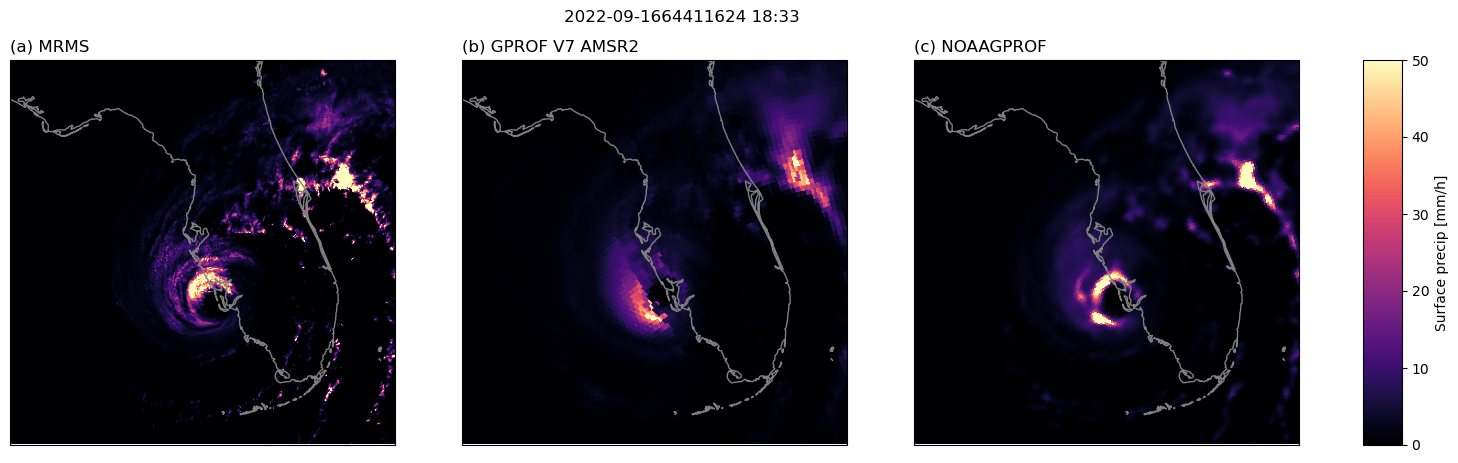

In [35]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

crs = area_def.to_cartopy_crs()
ext = area_def.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])
gs = GridSpec(1, 4, width_ratios=[1.0, 1.0, 1.0, 0.1])

norm = Normalize(0, 50)
cmap = "magma"

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(gs[0, 0], projection=crs)
ax.imshow(mrms_data.precip_rate.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(a) MRMS", loc="left")

ax = fig.add_subplot(gs[0, 1], projection=crs)
ax.imshow(gprof_data.surface_precipitation.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(b) GPROF V7 AMSR2", loc="left")

ax = fig.add_subplot(gs[0, 2], projection=crs)
m = ax.imshow(results_noaagprof.surface_precip.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(c) NOAAGPROF", loc="left")

ax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=ax, label="Surface precip [mm/h]")

time_range = granule.time_range
ctime = time_range.start + 0.5 * (time_range.end - time_range.start)
plt.suptitle(ctime.strftime("%Y-%m-%s %H:%M"))



## 3D Plot

In [46]:
!wget https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg

--2024-10-11 11:06:55--  https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg
Resolving eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)... 129.164.142.12, 2001:4d0:2310:170::12
Connecting to eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)|129.164.142.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2566770 (2.4M) [image/jpeg]
Saving to: ‘world.topo.bathy.200412.3x5400x2700.jpg’

world.topo.bathy.20 100%[===================>]   2.45M  4.27MB/s    in 0.6s    

2024-10-11 11:06:56 (4.27 MB/s) - ‘world.topo.bathy.200412.3x5400x2700.jpg’ saved [2566770/2566770]



In [21]:
import numpy as np
import pyvista as pv
pv.start_xvfb()

In [21]:
import numpy as np
import pyvista as pv

# Load the NASA Blue Marble texture image
texture_url = "world.topo.bathy.200412.3x5400x2700.jpg"
texture = pv.read_texture(texture_url)

# Define the limits of the region (latitude and longitude limits)
lat_min, lat_max = 20, 60  # Latitude range (degrees)
lon_min, lon_max = -100, 20  # Longitude range (degrees)

# Create a grid/plane where the texture will be mapped
nx, ny = 100, 100  # Number of points in the x and y directions (adjust for resolution)
x = np.linspace(lon_min, lon_max, nx)
y = np.linspace(lat_min, lat_max, ny)
xx, yy = np.meshgrid(x, y)
zz = np.zeros_like(xx)  # Z-coordinate is zero (flat plane)

# Convert grid to a PyVista structured grid
plane = pv.StructuredGrid(xx, yy, zz)
plane.texture_map_to_plane(inplace=True)
# Apply the Blue Marble texture to the plane

# Create a plotter and add the plane with the texture
plotter = pv.Plotter()
plotter.add_mesh(plane, texture=texture)

# Set plotter view to focus on the plane (no curvature)
plotter.view_xy()

# Show the plot

In [ ]:
plotter.show()

ERROR:root:Could not find a decent config
Xlib:  extension "GLX" missing on display ":99.0".
Xlib:  extension "GLX" missing on display ":99.0".
2024-10-11 11:24:02.508 (   1.516s) [    7FA06ECDA740]vtkXOpenGLRenderWindow.:256    ERR| vtkXOpenGLRenderWindow (0x55e7aa18ad80): Could not find a decent config

ERROR:root:Could not find a decent visual
2024-10-11 11:24:02.510 (   1.518s) [    7FA06ECDA740]vtkXOpenGLRenderWindow.:476    ERR| vtkXOpenGLRenderWindow (0x55e7aa18ad80): Could not find a decent visual

